In [56]:
import os
from glob import glob
import numpy as np

import pandas as pd
import prince
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

In [57]:
# Path to dataset
PATH = '/cdtshared/wearables/students/group5/'

# Features from biobank
features = pd.read_pickle(PATH+"imputed_dataset.pkl")

In [58]:
features_of_interest = list(set(list(features.columns)) - set(['acc.overall.avg']))

Y = features['acc.overall.avg']
X = features[features_of_interest]

In [59]:
# identify the categorical features
categorical_features = []
for columns in list(X.columns):
    if features[columns].dtype=='object':
        categorical_features.append(columns)
        
numeric_features = list(set(features_of_interest) - set(categorical_features))
X[numeric_features] = X[numeric_features].apply(pd.to_numeric)

In [60]:
X_enc = X
Y = Y.to_numpy()

In [61]:
# Split into training and testing, 70:20:10
X_train, X_test, y_train, y_test = train_test_split(X_enc, Y, test_size=0.3)

In [62]:
# Split into training and validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1/(0.1 + 0.2))

In [63]:
# Only keep features which have been split appropriately so all classes are present (needed for FAMD)
keep = []
for clmn in X_enc[categorical_features].columns:
    train_cats = set(X_train[clmn].unique())
    val_cats = set(X_val[clmn].unique())
    test_cats = set(X_test[clmn].unique())
    keep.append(train_cats == val_cats == test_cats)

keep_columns_cat = X_enc[categorical_features].columns[keep]
keep_columns = list(keep_columns_cat) + numeric_features

X_train = X_train[keep_columns]
X_val = X_val[keep_columns]
X_test = X_test[keep_columns]

In [64]:
print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_val.shape)
print("Shape of test set:", X_test.shape)

Shape of training set: (69589, 43)
Shape of validation set: (19882, 43)
Shape of test set: (9942, 43)


In [65]:
famd = prince.FAMD(n_components=30, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)
famd = famd.fit(X_train)

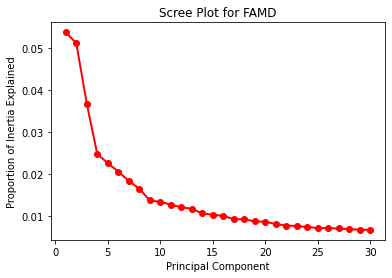

In [66]:
# Scree plot
PC_values = np.arange(30) + 1
plt.plot(PC_values, famd.explained_inertia_, 'ro-', linewidth=2)
plt.title('Scree Plot for FAMD')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Inertia Explained')
plt.show()

In [54]:
# Select top 15 principal components
famd = prince.FAMD(n_components=15, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)
famd.fit(X_train)
X_pca_train = famd.transform(X_train)
X_pca_val = famd.transform(X_val)
X_pca_test = famd.transform(X_test)

In [55]:
with open('/cdtshared/wearables/students/group5/XtrainFAMD.pkl','wb') as f:
    pickle.dump(X_pca_train, f)
with open('/cdtshared/wearables/students/group5/XvalFAMD.pkl','wb') as f:
    pickle.dump(X_pca_val, f)
with open('/cdtshared/wearables/students/group5/XtestFAMD.pkl','wb') as f:
    pickle.dump(X_pca_test, f)
with open('/cdtshared/wearables/students/group5/ytrainFAMD.pkl','wb') as f:
    pickle.dump(y_train, f)
with open('/cdtshared/wearables/students/group5/yvalFAMD.pkl','wb') as f:
    pickle.dump(y_val, f)
with open('/cdtshared/wearables/students/group5/ytestFAMD.pkl','wb') as f:
    pickle.dump(y_test, f)